# Note 1: Train-Test Data Splits

## 0. Overview

In this study, we will run several simulations to demonstrate the importance of splitting our study data into training and testing sets for model validation.

Suppose we randomly sampled $p$ vairables, $x_1, x_2, \dots, x_p$, and a response variable, $y$, independently from a standard normal distribution $\mathcal{N}(0, 1)$. Although $y$ is independent from the variables $x_1, x_2, \dots, x_p$, we can still define a linear relationship as follows:

$$

y = \beta_0 + \sum_{i=1}^p \beta_i x_i + \epsilon

$$

$$
y \sim \mathcal{N}(0, 1)
$$

$$
x_i \sim \mathcal{N}(0, 1)
$$

$$

\epsilon \sim \mathcal{N}(0, 1)

$$


where $\beta_0, \beta_1, \dots, \beta_p$ are the linear coefficients and $\epsilon$ is the error term, which is also sampled from the standard normal distribution $\mathcal{N}(0, 1)$. To help us explain the idea, we can express the above equation in the matrix form:

$$

\mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \boldsymbol{\epsilon}

$$

where

$$

\mathbf{y} = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}, \quad

\mathbf{X} = \begin{bmatrix} 1 & x_{11} & x_{12} & \dots & x_{1p} \\ 1 & x_{21} & x_{22} & \dots & x_{2p} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_{n1} & x_{n2} & \dots & x_{np} \end{bmatrix}, \quad

$$

and

$$

\boldsymbol{\beta} = \begin{bmatrix} \beta_0 \\ \beta_1 \\ \vdots \\ \beta_p \end{bmatrix}, \quad

\boldsymbol{\epsilon} = \begin{bmatrix} \epsilon_1 \\ \epsilon_2 \\ \vdots \\ \epsilon_n \end{bmatrix}

$$

$n$ is the number of observations.


Before we start, we need to import the following libraries to save us some time.

In [1]:
# python libs imports
import numpy as np # linear algebra, use `np`as the alias
import pandas as pd # dataframes, use `pd` as the alias
from scipy.stats import pearsonr # correlation coefficient
from sklearn.linear_model import LinearRegression # OLS
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt # native visualization
import seaborn as sns # visualization but more friendly interface

# local imports
from note01 import make_data, get_dataframe

## 1. Spurious causal relationship

### 1.1 Hypothesis

Since the response variable $y$ is independent from the variables $x_1, x_2, \dots, x_p$, with the minimized error term $\boldsymbol{\epsilon}$, we expect that the linear coefficients $\boldsymbol{\beta}$ are all zero or relatively small. In other words, we expect that the response variable $y$ is not related to $\mathbf{X}$. To test this hypothesis, we can use the Pearson's correlation coefficient $r$ to measure the relationship between the response variable $y$ and the fitted $\mathbf{\hat{y}}$:

$$

\mathbf{r} (\mathbf{y}, \mathbf{\hat{y}}) = \frac{\mathrm{cov}(\mathbf{y},\mathbf{\hat{y}})}{\sqrt{\mathrm{var}(\mathbf{y}) \mathrm{var}(\mathbf{\hat{y}})}}

$$

where

$$

\mathbf{\hat{y}} = \mathbf{X}\boldsymbol{\beta}

$$

and $\mathrm{cov}(\mathbf{y}, \mathbf{\hat{y}})$ is the covariance between $\mathbf{y}$ and $\mathbf{\hat{y}}$, and $\mathrm{var}(\mathbf{y})$ and $\mathrm{var}(\mathbf{\hat{y}})$ are the variances of $\mathbf{y}$ and $\mathbf{\hat{y}}$, respectively. Suppose we believe that $r=0.3$ is a relatively strong correlation, then we can test the hypothesis as follows:

$$

\begin{cases}

    H_0: \mathbf{r} (\mathbf{y}, \mathbf{\hat{y}}) \leq 0.3 \\
    H_1: \mathbf{r} (\mathbf{y}, \mathbf{\hat{y}}) > 0.3

\end{cases}

$$

If we successfully reject the null hypothesis $H_0$, then we can conclude that the response variable $y$ may have a high correlation with $\mathbf{X}$, even when $y$ is independent from $x_1, x_2, \dots, x_p$.



### 1.2 Data simulation

We can follow our hypothesis and simulate the data as follows. First, we set the number of observations $n$ and the number of variables $p$:

In [113]:
n = 100 # number of observations (cows)
p = 5 # number of variables (features)
# generate a matrix that has n rows and p columns (n x p)
X, y = make_data(n, p)
data = get_dataframe(X, y)

,id,x_1,x_2,x_3,x_4,x_5,y
0,cow 1,-0.4629,1.1118,0.2634,1.3645,-0.1877,-0.6146
1,cow 2,-1.0881,-1.5057,-1.5067,-0.1734,-0.0501,-0.5000
2,cow 3,-0.5922,1.5023,0.2031,1.2188,-0.5607,1.4314
3,cow 4,0.0559,-0.6541,0.6829,0.3872,-2.1360,0.1411
4,cow 5,-0.0527,1.2478,1.5840,1.2706,-0.4538,-1.2841
...,...,...,...,...,...,...,...
95,cow 96,-0.9514,0.6546,-1.4692,-0.2960,1.0107,1.1070
96,cow 97,1.1497,0.8142,-1.0239,-0.2815,1.2933,-1.2256
97,cow 98,-1.6270,0.0500,1.1248,-0.0558,-0.6296,0.3849
98,cow 99,0.2333,0.0958,-1.6288,0.1806,0.4115,0.9195


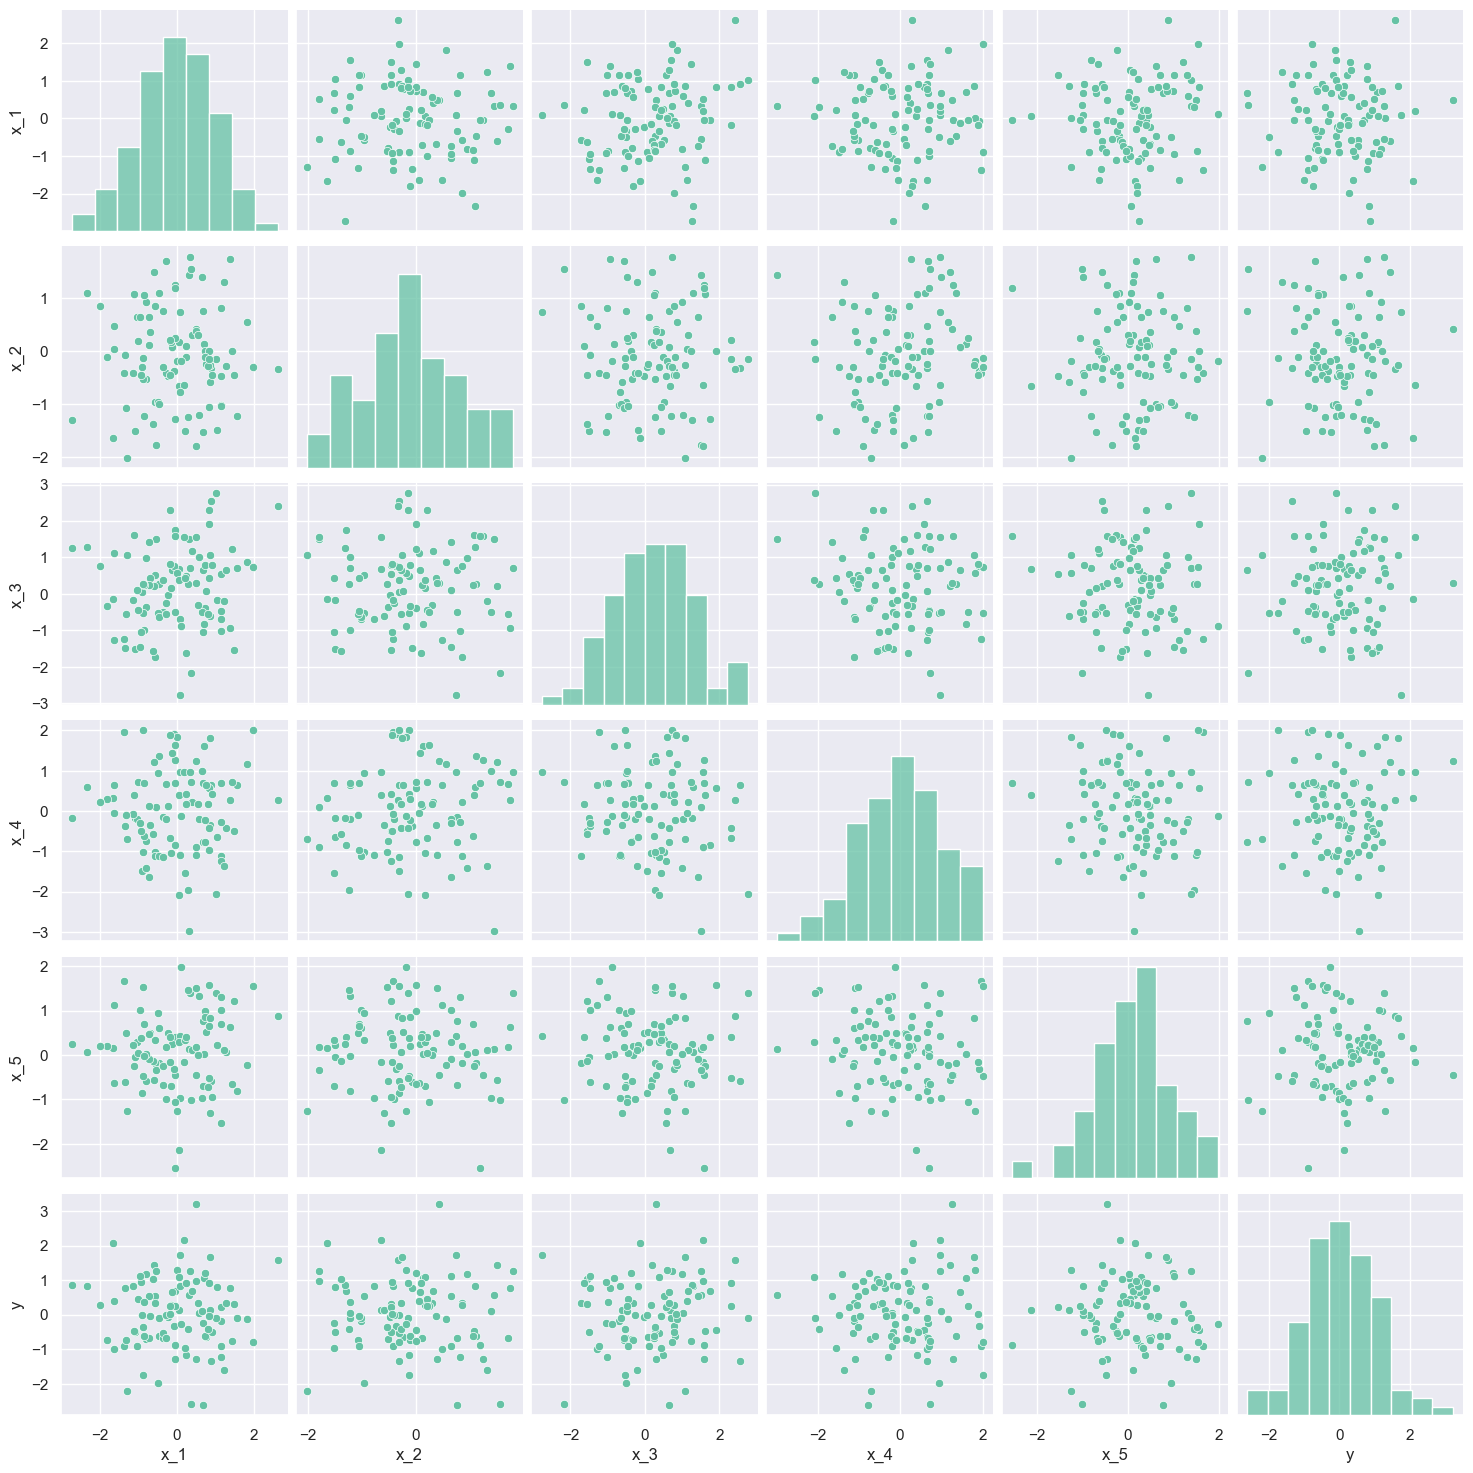

In [114]:
display(data)
sns.pairplot(data)

### 1.3 Linear Regression

Now, we can fit a linear regression model to the simulated data and calculate the Pearson's correlation coefficient $r$ between the response variable $\mathbf{y}$ and the fitted $\mathbf{\hat{y}}$:

In [4]:
# instantiate a linear regression model
linear_model = LinearRegression()
# estimate the coefficients beta and store them in the model
linear_model.fit(X, y)
# usse the stored beta to obtain the predicted values y_hat = Xb
y_hat = linear_model.predict(X)
pearsonr(y, y_hat)

PearsonRResult(statistic=0.21201295359217526, pvalue=0.034208058818617215)

To simplify the script, we need to wrap the above steps into a function:

In [5]:
def get_yhat_by_ols(X, y):
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_hat = linear_model.predict(X)
    return y_hat

y_hat = get_yhat_by_ols(X, y)
pearsonr(y, y_hat)

PearsonRResult(statistic=0.21201295359217526, pvalue=0.034208058818617215)

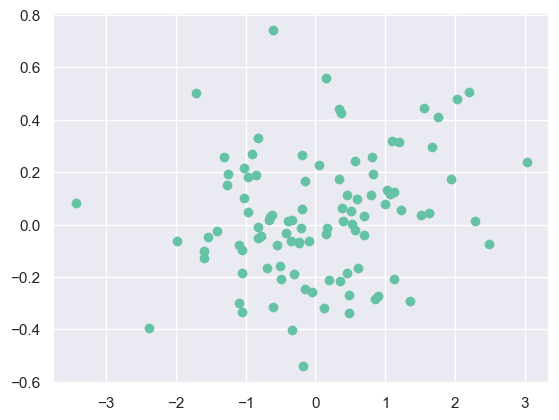

In [6]:
plt.scatter(x=y, y=y_hat)

The correlation should be low, which meets our expectation as all the $x$ variables are independent from $y$.

### 1.4 Iterate the same process for 1,000 times

We cannot test our hypothesis with only one simulation. We need to repeat the same process for multiple times to form a distribution of the correlation coefficient $r$. We can use the following script to repeat the same process for 1,000 times:

In [12]:
# always define the parameters at the top of the script, not hard-coded
n = 100
p = 5
niter = 1000
thresd = 0.3 # threshold for the alternative hypothesis

# run the simulation
dist_r = []
for i in range(niter):
    X, y = make_data(n, p) # sample a dataset
    y_hat = get_yhat_by_ols(X, y) # obtain the fitted values
    r = pearsonr(y, y_hat)[0] # the first element is the correlation coefficient
    dist_r.append(r) # concatenate the correlation coefficient to the list

In [8]:
# check the first 5 correlation coefficients
dist_r[:5]

[0.247379309467936,
 0.2324809345097141,
 0.23209246667092334,
 0.12157551712342057,
 0.16364629461566735]

The `p-value` is the probability of observing a correlation coefficient $r$ less or equal to the arbitrary threshold `0.3`. If the `p-value` is less than the significance level $\alpha = 0.05$, then we can reject the null hypothesis $H_0$.

In [13]:
def get_p_value(dist, threshold):
    dist = np.array(dist)
    bol_pass = dist <= threshold
    p_value = np.mean(bol_pass)
    return p_value.round(4)

p_value = get_p_value(dist_r, threshold=thresd)
p_value

0.891

(0.0, 1.0)

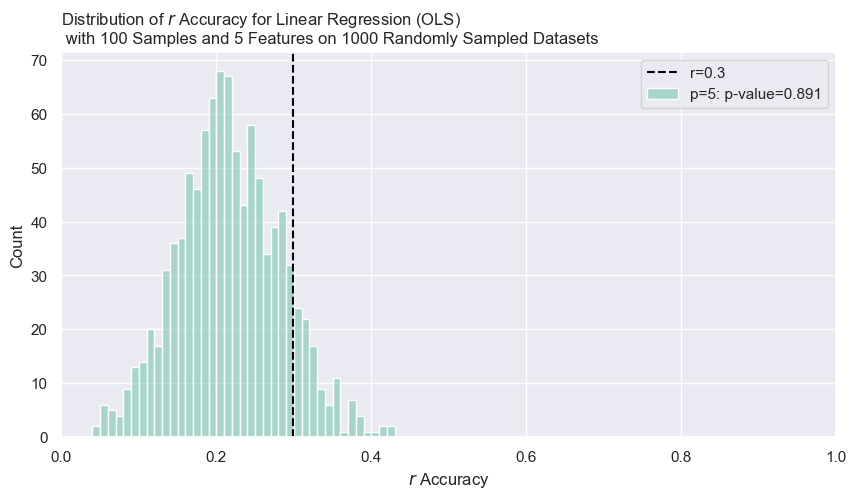

In [16]:
sns.set_theme(style="darkgrid", palette="Set2")
plt.figure(figsize=(10, 5))
sns.histplot(dist_r, binwidth=.01, alpha=0.5, label=f"p={p}: p-value={p_value}")

# post-process the plot
plt.axvline(x=thresd, color="black", linestyle="--", label=f"r={thresd}")
plt.title(f"Distribution of $r$ Accuracy for Linear Regression (OLS) \n with {n} Samples and {p} Features on {niter} Randomly Sampled Datasets", loc="left")
plt.legend()
plt.xlabel("$r$ Accuracy")
plt.xlim(0, 1)

### 1.5 Extend the simulation to different $p$

What if we include more predictors in the simulation? Will the correlation coefficient $r$ be higher? We can extend the simulation to different $p$ and see how the correlation coefficient $r$ changes. First, let's wrap the above steps into a function:

In [17]:
def ols_r_dist(n, p, niter):
    # run the simulation
    dist_r = []
    for i in range(niter):
        X, y = make_data(n, p) # sample a dataset
        y_hat = get_yhat_by_ols(X, y) # obtain the fitted values
        r = pearsonr(y, y_hat)[0] # the first element is the correlation coefficient
        dist_r.append(r) # concatenate the corre
    return np.array(dist_r)

Now, we will change the number of predictors $p$ and store the $r$ distributions into a list `results`. This step may take a while to run:

In [30]:
# parameters
n = 100
niter = 1000
thresd = 0.3

# simulation
results = {}
for p in [5, 10, 20, 40, 60, 80]:
    results[p] = ols_r_dist(n=n, p=p, niter=niter)

If you have problem running the script above, you can load the pre-saved results by the following script:

In [115]:
results = pd.read_csv("out/note01_ols_r_dist.csv")
results

,5,10,20,40,60,80
0,0.258265,0.319623,0.412470,0.660699,0.851334,0.947000
1,0.142738,0.335289,0.453721,0.515662,0.820995,0.870251
2,0.204003,0.273373,0.409378,0.594276,0.797535,0.925243
3,0.247320,0.262237,0.495336,0.681703,0.761478,0.894643
4,0.320979,0.354078,0.463485,0.668496,0.757545,0.910602
...,...,...,...,...,...,...
995,0.198980,0.294568,0.325158,0.617601,0.750676,0.830776
996,0.224228,0.258422,0.508978,0.648600,0.769811,0.895568
997,0.308602,0.307252,0.435641,0.648249,0.841598,0.890264
998,0.123488,0.304766,0.374337,0.700940,0.760747,0.879828


Let's visualize the results:

(0.0, 1.0)

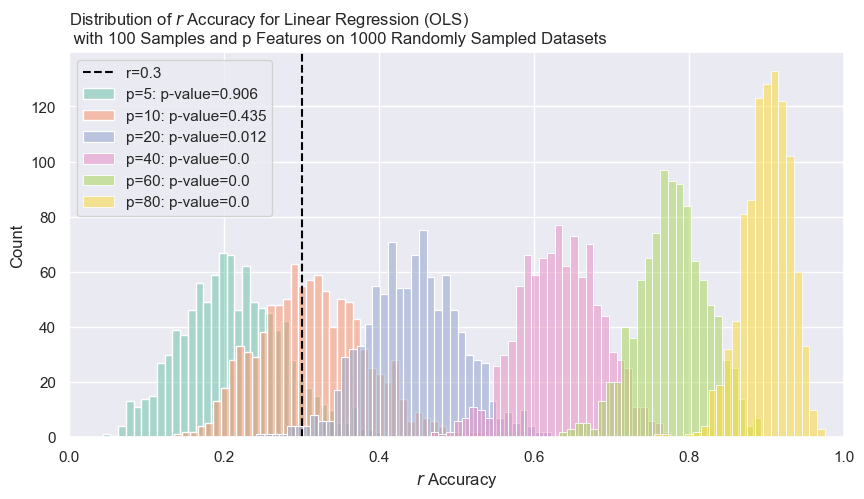

In [31]:
plt.figure(figsize=(10, 5))
for p in results.keys():
    dist = results[p]
    p_value = get_p_value(dist, threshold=thresd)
    sns.histplot(dist, binwidth=.01, alpha=0.5, label=f"p={p}: p-value={p_value}")

plt.axvline(x=thresd, color="black", linestyle="--", label=f"r={thresd}")
plt.title(f"Distribution of $r$ Accuracy for Linear Regression (OLS) \n with {n} Samples and p Features on {niter} Randomly Sampled Datasets", loc="left")
plt.legend()
plt.xlabel("$r$ Accuracy")
plt.xlim(0, 1)

### 1.6 Discussion

As you can see from the above plot, we can reject the null hypothesis $H_0$ after $p$ increases to `20`. When $p=20$, only `0.012` of the simulations have $r$ smaller than or equal to `0.3`. It indicates that `98.8%` of the time, a spurious causal relationship may be falsely claimed as a high $r$ accuracy is observed. Therefore, we need a way to validate such relationship and the prediction models.

## 2. Train/test data splits

### 2.1 Hypothesis

If we reject the null hypothesis in the previous section, then how can we avoid such spurious correlation? One way is to split our data into training and testing sets. In our equation, instead of estimating $\boldsymbol{\beta}$ using the entire dataset, we can estimate $\boldsymbol{\beta}$ using the partial dataset, known as the training set, and the remaining dataset, known as the testing set, can be used to validate the model predicatability:

$$

\mathbf{y_{trian}} = \mathbf{X_{train}} \boldsymbol{\beta} + \boldsymbol{\epsilon}
$$

$$

\mathbf{\hat{y}_{test}} = \mathbf{X_{test}} \boldsymbol{\beta}

$$

We can then calculate $r$ to test the hypothesis:

$$

\begin{cases}

    H_0: \mathbf{r} (\mathbf{y_{test}}, \mathbf{\hat{y}_{test}}) \leq 0.3 \\
    H_1: \mathbf{r} (\mathbf{y_{test}}, \mathbf{\hat{y}_{test}}) > 0.3

\end{cases}
$$

### 2.2 Data simulation

In [32]:
n = 100
p = 20
# generate a matrix that has n rows and p columns (n x p)
X, y = make_data(n, p)
# split the data into training (80%) and testing sets (20%)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
# inspect the data dimensions
print("X shape: ", X.shape)
print("X train shape: ", x_train.shape)
print("X test shape: ", x_test.shape)
print("----------------------------")
print("y shape: ", y.shape)
print("y train shape: ", y_train.shape)
print("y test shape: ", y_test.shape)

X shape:  (100, 20)
X train shape:  (80, 20)
X test shape:  (20, 20)
----------------------------
y shape:  (100,)
y train shape:  (80,)
y test shape:  (20,)


### 2.3 Linear Regression with train/test data splits

Now we need to modify the OLS function to take both `x_train` and `x_test`

In [43]:
# Old function
def get_yhat_by_ols(X, y):
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_hat = linear_model.predict(X)
    return y_hat

# Your new function
def get_yhat_by_ols_val(x_train, x_test, y_train):
    linear_model = LinearRegression()
    linear_model.fit(x_train, y_train)
    y_hat = linear_model.predict(x_test)
    return y_hat

Also, we need to modify the script to generate `r` distribution:

In [63]:
# Old function
def ols_r_dist(n, p, niter):
    dist_r = []
    for i in range(niter):
        X, y = make_data(n, p) # sample a dataset
        y_hat = get_yhat_by_ols(X, y) # obtain the fitted values
        r = pearsonr(y, y_hat)[0] # the first element is the correlation coefficient
        dist_r.append(r) # concatenate the corre
    return np.array(dist_r)

# Your new function
def ols_r_dist_val(n, p, niter):
    dist_r = []
    for i in range(niter):
        X, y = make_data(n, p)
        # the new part --------------------
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        y_hat = get_yhat_by_ols_val(x_train, x_test, y_train)
        # ----------------------------
        r = pearsonr(y_test, y_hat)[0]
        dist_r.append(r)
    return np.array(dist_r)

### 2.4 Iterate the same process for 1,000 times

Like the previous section, we need to repeat the same process for 1,000 times:

In [62]:
n = 100
p = 20
n_iter = 1000
thresd = 0.3

# without train-test split
r_dist = ols_r_dist(n=n, p=p, niter=n_iter)
p_value = get_p_value(r_dist, threshold=thresd)
# with train-test split
r_dist_val = ols_r_dist_val(n=n, p=p, niter=n_iter)
p_value_val = get_p_value(r_dist_val, threshold=thresd)

Visualize the results:

Text(0.5, 0, '$r$ Accuracy')

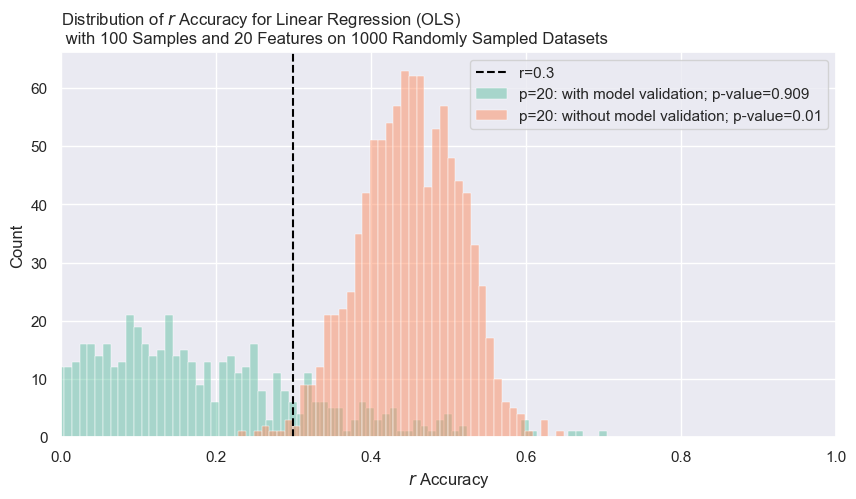

In [64]:
plt.figure(figsize=(10, 5))
sns.histplot(r_dist_val, binwidth=.01, alpha=0.5, label=f"p={p}: with model validation; p-value={p_value_val}")
sns.histplot(r_dist, binwidth=.01, alpha=0.5, label=f"p={p}: without model validation; p-value={p_value}")
plt.axvline(x=thresd, color="black", linestyle="--", label=f"r={thresd}")
plt.title(f"Distribution of $r$ Accuracy for Linear Regression (OLS) \n with {n} Samples and {p} Features on {niter} Randomly Sampled Datasets", loc="left")
plt.legend()
plt.xlim(0, 1)
plt.xlabel("$r$ Accuracy")

### 2.5 Bring the causal relationship back to the simulation

After knowning how to avoid the spurious correlation, we can see what would happend if there is a real causal relationship between $y$ and $x_1, x_2, \dots, x_p$. By assigning the parameter `p_aasoc`, the linear coefficients $\beta$ will be sampled from a normal distribution $\mathcal{N}(0, 1)$ and to be added to generate the response variable $y$:


In [74]:
n = 100 # number of observations (cows)
p = 5 # number of variables (features)
# p_assoc is the number of associated variables
X, y = make_data(n, p, p_assoc=4)
data = get_dataframe(X, y)

,id,x_1,x_2,x_3,x_4,x_5,y
0,cow 1,-1.5574,-0.4696,1.9922,1.1113,1.0025,1.7523
1,cow 2,0.7810,1.6037,-0.5046,-0.2516,1.2177,0.9369
2,cow 3,-0.0866,0.0080,-2.1779,-0.7709,-1.0248,-1.1445
3,cow 4,-0.0067,0.3515,-1.2465,-0.8807,-0.1334,-0.3273
4,cow 5,-1.0169,0.7567,-1.1420,-0.2269,0.2591,-0.8560
...,...,...,...,...,...,...,...
95,cow 96,1.9481,2.2278,-0.1051,1.0435,0.8798,-0.5287
96,cow 97,-0.1173,-1.2573,-1.8335,0.6633,-0.0785,1.0887
97,cow 98,0.6061,-0.6419,-2.3092,0.6999,-0.4119,0.8173
98,cow 99,1.4376,-1.0259,-1.4877,-0.3060,-0.3259,2.9126


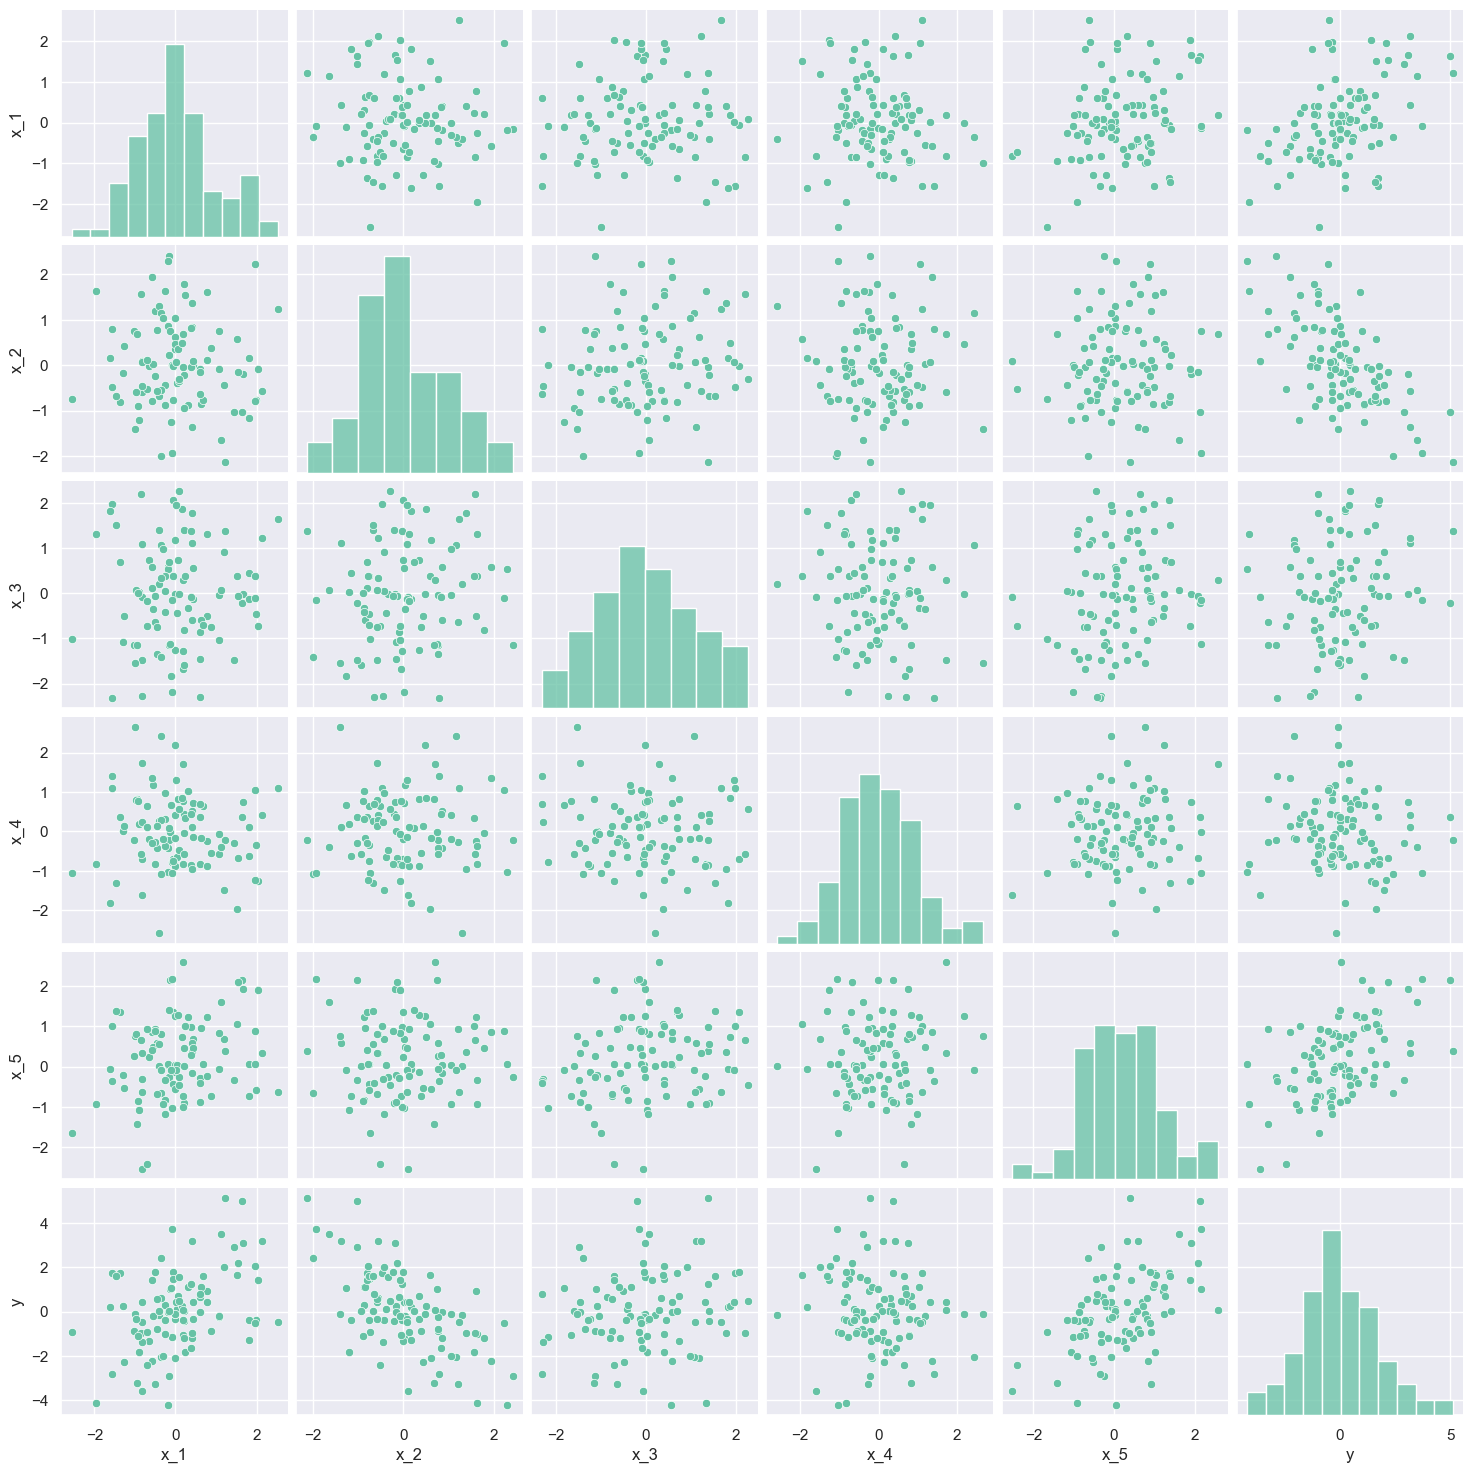

In [75]:
# inspect the data
display(data)
sns.pairplot(data)

We need to modify the `ols_r_dist()` and `ols_r_dist_val()` functions to let them take the causal relationship `p_assoc` as an argument:

In [94]:
# OLS without train-test split
def ols_r_dist(n, p, niter, p_assoc):
    dist_r = []
    for i in range(niter):
        # the new part --------------------
        X, y = make_data(n, p, p_assoc=p_assoc)
        # ----------------------------
        y_hat = get_yhat_by_ols(X, y)
        r = pearsonr(y, y_hat)[0]
        dist_r.append(r)
    return np.array(dist_r)

# OLS with train-test split
def ols_r_dist_val(n, p, niter, p_assoc):
    dist_r = []
    for i in range(niter):
        # the new part --------------------
        X, y = make_data(n, p, p_assoc=p_assoc)
        # ----------------------------
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        y_hat = get_yhat_by_ols_val(x_train, x_test, y_train)
        r = pearsonr(y_test, y_hat)[0]
        dist_r.append(r)
    return np.array(dist_r)

Run the simulation

In [112]:
# parameters
n = 100
p = 20
ls_p_assoc = [0, 5]
niter = 1000
thresd = 0.3
# simulation
results = {}
for p_assoc in ls_p_assoc:
    results[p_assoc] = {}
    results[p_assoc]["with validation"] = ols_r_dist_val(n=n, p=p,
                                                        niter=niter, p_assoc=p_assoc)
    results[p_assoc]["without validation"] = ols_r_dist(n=n, p=p,
                                                        niter=niter, p_assoc=p_assoc)

Visualize the results

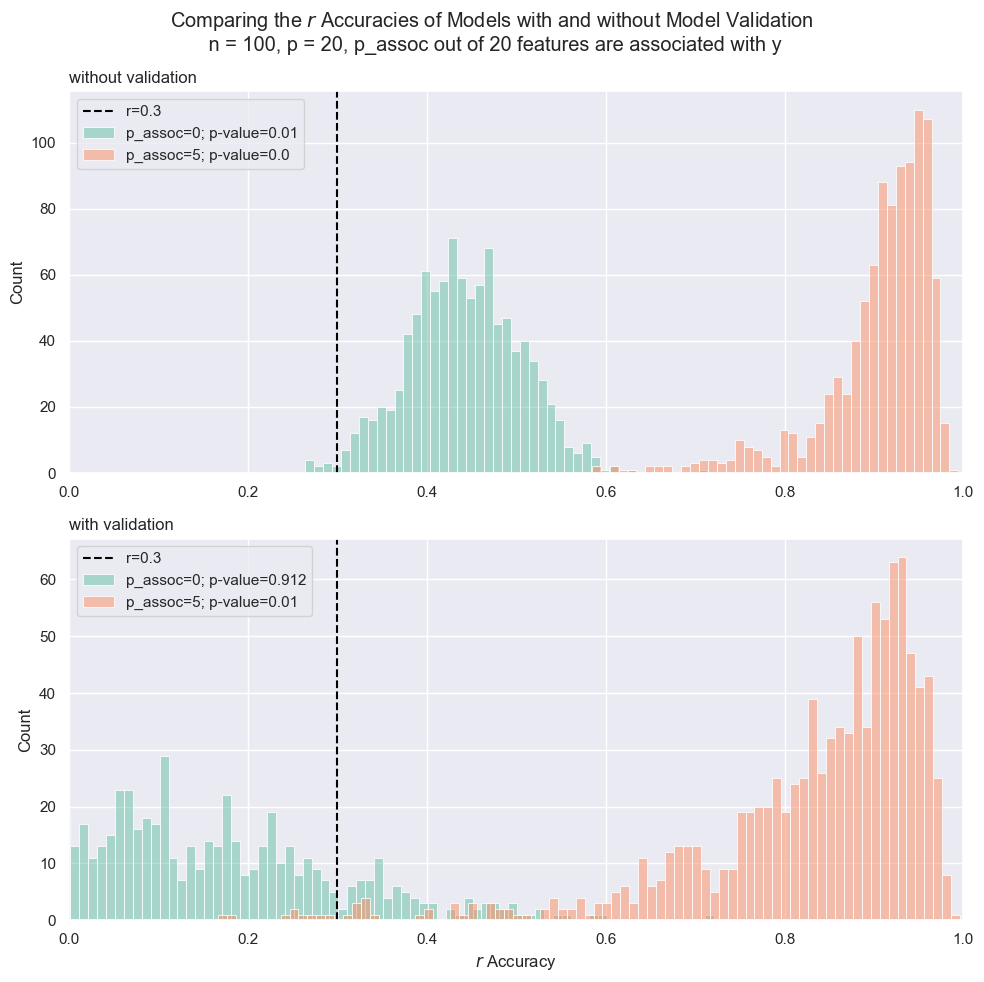

In [111]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i, cv in enumerate(["without validation", "with validation"]):
    axs[i].set_title(cv, loc="left")
    axs[i].axvline(x=thresd, color="black", linestyle="--", label=f"r={thresd}")
    axs[i].set_xlim(0, 1)
    for p_assoc in ls_p_assoc:
        r2 = results[p_assoc][cv]
        p_value = get_p_value(r2, threshold=thresd)
        sns.histplot(r2, binwidth=.01, alpha=0.5,
                    label=f"p_assoc={p_assoc}; p-value={p_value}",
                    ax=axs[i])
    axs[i].legend()

plt.suptitle(f"Comparing the $r$ Accuracies of Models with and without Model Validation\n n = {n}, p = {p}, p_assoc out of {p} features are associated with y")
plt.xlabel("$r$ Accuracy")
plt.tight_layout()

## 3. Conclusion

In this study, we have demonstrated how to use train/test data splits to avoid a spurious correlation. We have also shown that the train/test data splits can lead to different conclusions when there is a real causal relationship between the response variable and the predictors. Therefore, it is always important to validate the model predicatability using the train/test data splits.